# Chapter 23 Ordinal Predicted Variable, Two Group Case

- Figure 23.4
- Simulation data is generated using the true parameters of the two group data in DBDA book.
- As the number of data gets larger, the uncertainties of the estimates gets smaller.

In [2]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# numpyro
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.nn import softmax, softplus
from jax.scipy.special import logsumexp, logit, expit

import numpyro
import numpyro as npr
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)  # 4 chains in MCMC

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scipy
import scipy.stats as stats
from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [3]:
%load_ext watermark
%watermark -p pandas,numpy,matplotlib,seaborn,scipy,arviz,numpyro,jax

pandas    : 1.2.1
numpy     : 1.19.5
matplotlib: 3.3.3
seaborn   : 0.11.1
scipy     : 1.6.0
arviz     : 0.11.2
numpyro   : 0.5.0
jax       : 0.2.8



## Helper Functions

In [4]:
# these helper functions convert numpy array into jax.numpy array
# then after computation, convert back to numpy array
def prior_predictive(model, d):
    Pred = Predictive(model, num_samples=2021)
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
    samples = Pred(random.PRNGKey(0), **jax_data)
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

def np2jnp(samples):
    jnp_samples = {k: np.array(v) if isinstance(v, np.ndarray) else v for k, v in samples.items() }
    return jnp_samples

def jnp2np(samples):
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

def mcmc_sampling(model, d, num_warmup=500, num_samples=2000, num_chains=4):
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
    # MCMC
    mcmc_engine = MCMC(NUTS(model), num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_engine.run(random.PRNGKey(0), **jax_data)
    samples = mcmc_engine.get_samples()
    #
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    mcmc_engine.print_summary()
    return np_samples

In [5]:
def print_shapes(s):
    for k in s.keys():
        print(f'{k:12} ', s[k].shape) 

In [6]:
def plot_npdfs(a, method=None): #='hist'):
    fig, axes = plt.subplots(1, a.shape[1], figsize=(13,2))
    for i, ax in enumerate(axes):
        if method == 'hist':
            ax.hist(a[:,i], bins=20)
        else:
            az.plot_posterior(a[:,i], ax=ax)

In [7]:
def plot_thresholds(thresh_samples):
    thmat = thresh_samples # +1 is necessary to shift to the 1-based world as in DBDA book
    th_mean = np.repeat(thmat.mean(axis=1)[:,np.newaxis], thmat.shape[1], axis=1)
    # the same dimensions: th_mean.shape, thmat.shape

    plt.vlines(x=thmat.mean(axis=0), ymin=th_mean.min(), ymax=th_mean.max(), 
               colors='#DDBBAA', linestyles='dashed', alpha=.4)
    plt.scatter(thmat, th_mean, alpha=.1, s=1);
    plt.xticks(ticks=thmat.mean(axis=0))
    plt.xlabel('thresholds')
    plt.ylabel('Mean Thresholds (per sample)')

## Simulation Data

In [89]:
theta = np.array([1.5, 2.5, 3.5, 4.5])
mus = [0.7, 1.5]
sigmas = [1.6, 1.6]
ysamples = []
nsamples = 5000
for mu, sigma in zip(mus, sigmas):
    mu = mu - 1
    dnorm = stats.norm(mu, sigma)
    cdf = dnorm.cdf(theta - 1)
    probs = cdf[1:] - cdf[:-1]
    print(cdf)
    probs = np.concatenate( (np.array([cdf[0]]), probs) )
    probs = np.concatenate((probs, np.array([1.-cdf[-1]])))
    print(probs, probs.sum())
    y = stats.multinomial(n=1, p=probs).rvs(nsamples)
    ysamples.append(y)
#
ysamples = np.argmax(np.concatenate(ysamples), axis=1) + 1  # 1-based
print('ysamples', ysamples.shape)
df = pd.DataFrame({'Y': ysamples, 'X': np.array([0]*nsamples + [1]*nsamples)})

[0.69146246 0.86970548 0.95994084 0.99122552]
[0.69146246 0.17824302 0.09023536 0.03128468 0.00877448] 1.0
[0.5        0.73401447 0.89435023 0.96960364]
[0.5        0.23401447 0.16033576 0.07525341 0.03039636] 1.0
ysamples (10000,)


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       10000 non-null  int64
 1   X       10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [91]:
df.Y.unique(), df.X.unique()

(array([1, 3, 2, 5, 4]), array([0, 1]))

In [92]:
# Number of outcomes
nYlevels = len(df.Y.unique())
nGroups = len(df.X.unique())
print(f'nYlevels = {nYlevels}  nGroups = {nGroups}')

nYlevels = 5  nGroups = 2


In [93]:
Y = df.Y.values.astype(int) - 1  # python index starts from 0
YY = np.array([Y[df.X == g] for g in df.X.unique()])
print('Y = ', Y)
print('Y levels = ', np.unique(Y))
print('nYlevels: ', nYlevels)
YY

Y =  [0 0 2 ... 0 0 2]
Y levels =  [0 1 2 3 4]
nYlevels:  5


array([[0, 0, 2, ..., 3, 3, 0],
       [0, 1, 0, ..., 0, 0, 2]])

## Ordinal Probit, my own way

In [94]:
### 1. Just repeat

def getAmat(nYlevels):
    a = np.eye(nYlevels)
    for j in range(a.shape[0]-1):
        a[j+1,j] = -1 
    return a

def model_cat0(nGroups, nYlevels, Amat, y=None):
    # cut points
    with npr.plate('cut_plat', size=nYlevels-1):
        cuts = npr.sample('cuts_draw', dist.Exponential(1/2.)) # Notice: python index starts from 0, so is the outcome of Catgorical()
    cuts = jax.ops.index_update(cuts, jax.ops.index[0], 0.)  # cuts[0] = 0, cuts=[0, d1, d2, ..., d_{K-1}]
    cuts = jnp.cumsum(cuts)                                  # accumulate,  cuts=[0, d1, d1+d2, d1+d2+d2,..., \sum_k d_{k}]
    cuts = cuts * (nYlevels-2) / cuts[-1]  # cuts[5] == 5    # scale,       cuts=[0, c1, ... c_{K-2}, K-2]
    cuts = cuts + 0.5  # cuts[0] = 0.5, cuts[5] = 5.5        # shift        cuts=[.5, ..., K-2+.5]
#     cuts = jnp.concatenate((cuts, jnp.array([jnp.inf])))              # to convert to probs by multiply Amat
    npr.deterministic('cuts', cuts)
    print('cuts', cuts.shape)
       
    for i in range(nGroups):
        loc = npr.sample(f'loc_{i}', dist.Normal((1+nYlevels)/2., nYlevels))
        scale = npr.sample(f'sigma_{i}', dist.Uniform(low=nYlevels/1000., high=nYlevels*10))
        print('loc', loc.shape)
        
        cdfs = jax.scipy.stats.norm.cdf(cuts, loc=loc, scale=scale)  # probit function evaluation
        print('cdfs0 ', cdfs.shape)
        cdfs = jnp.concatenate((cdfs, jnp.array([1.])))              # to convert to probs by multiply Amat
        print('cdfs1 ', cdfs.shape)
        probs = jnp.dot(Amat, cdfs)     # now convert to probs
        print('probs0 ', probs.shape)
        probs = jnp.maximum(0., probs)  # just to be sure, this does not happend. prob = max(0, cdf[i] - cdf[i-1]), see the matrix A
        probs = probs / probs.sum() # just to be sure. numerical computation may produce small offset
        #
        npr.deterministic(f'cdfs_{i}', cdfs)
        npr.deterministic(f'probs_{i}', probs)
        #
        print(cdfs.shape, probs.shape)

        obs = npr.sample(f'obs_{i}', dist.Categorical(probs=probs.T), obs=y[i] if y is not None else None)
        print('obs ', obs.shape)

In [95]:
data_prior = dict(nGroups=nGroups, nYlevels=nYlevels, Amat=getAmat(nYlevels))  # for Prior Predictive

s = prior_predictive(model_cat0, data_prior)

[(f'{k:12} ', s[k].shape) for k in s.keys()]

cuts (4,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  ()
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  ()


[('cdfs_0       ', (2021, 5)),
 ('cdfs_1       ', (2021, 5)),
 ('cuts         ', (2021, 4)),
 ('cuts_draw    ', (2021, 4)),
 ('loc_0        ', (2021,)),
 ('loc_1        ', (2021,)),
 ('obs_0        ', (2021,)),
 ('obs_1        ', (2021,)),
 ('probs_0      ', (2021, 5)),
 ('probs_1      ', (2021, 5)),
 ('sigma_0      ', (2021,)),
 ('sigma_1      ', (2021,))]

In [96]:
%%time

a = mcmc_sampling(model_cat0, 
                  dict(nGroups=nGroups, nYlevels=nYlevels, Amat=getAmat(nYlevels), y=YY))

[(f'{k:12} ', a[k].shape) for k in a.keys()]

cuts (4,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  (5000,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  (5000,)
cuts (4,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  (5000,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  (5000,)
cuts (4,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  (5000,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  (5000,)
cuts (4,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  (5000,)
loc ()
cdfs0  (4,)
cdfs1  (5,)
probs0  (5,)
(5,) (5,)
obs  (5000,)

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cuts_draw[0]      1.99      2.02      1.37      0.00      4.58   7795.76      1.00
cuts_draw[1]      2.05      1.17      1.82      0.34      3.73   2918.52      1.00
cuts_draw[2]      2.03      1.16      1.81      0.28      3.64   2906.13      1.00
cuts_draw[3]      1.90      1.08      1.69      0.29      3.43   2918.95      1.00
       l

[('cdfs_0       ', (8000, 5)),
 ('cdfs_1       ', (8000, 5)),
 ('cuts         ', (8000, 4)),
 ('cuts_draw    ', (8000, 4)),
 ('loc_0        ', (8000,)),
 ('loc_1        ', (8000,)),
 ('probs_0      ', (8000, 5)),
 ('probs_1      ', (8000, 5)),
 ('sigma_0      ', (8000,)),
 ('sigma_1      ', (8000,))]

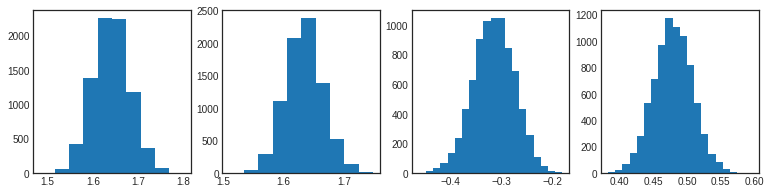

In [97]:
fig, axes = plt.subplots(1,4, figsize=(13,3))
axes[0].hist(a['sigma_0']);
axes[1].hist(a['sigma_1']);
axes[2].hist(a['loc_0'], bins=20);
axes[3].hist(a['loc_1'], bins=20);

In [98]:
a['cuts'][:,-1]

array([3.5      , 3.5      , 3.5      , ..., 3.5000002, 3.5      ,
       3.4999998], dtype=float32)

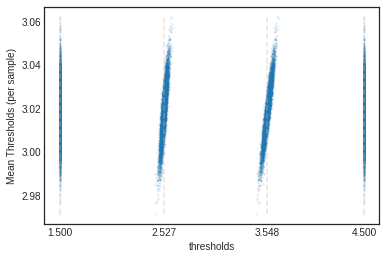

In [99]:
plot_thresholds(a['cuts'] + 1)

## Ordinal Probit, Book's way

In [100]:
def getAmat(nYlevels):
    a = np.eye(nYlevels)
    for j in range(a.shape[0]-1):
        a[j+1,j] = -1 
    return a

def model(nGroups, nYlevels, Amat, y=None):
    # cutpoints, we need K-1 thresholds
    cuts_init = jnp.array([i+.5 for i in range(nYlevels-1)])
    with npr.plate('cuts_draw_plate', size=nYlevels-1):
        cuts_normal = npr.sample('cuts_normal', dist.Normal(0., 2.)) 
    cuts = cuts_init + cuts_normal
    npr.deterministic('cuts_draw', cuts)
    
    cuts = jax.ops.index_update(cuts, jax.ops.index[0], 0.5)  # cuts[0] = .5 
    cuts = jax.ops.index_update(cuts, jax.ops.index[-1], nYlevels - 1 -.5)  # cuts[-1] = 5.5
    npr.deterministic('cuts', cuts)

    for i in range(nGroups):
        mu = npr.sample(f'mu_{i}', dist.Normal((1. + nYlevels) / 2, nYlevels))
        sigma = npr.sample(f'sigma_{i}', dist.Uniform(low=nYlevels/1000, high=nYlevels*10))

        # probit comp.
        cdfs = jax.scipy.stats.norm.cdf(cuts, loc=mu, scale=sigma)
        cdfs = jnp.concatenate((cdfs, jnp.array([1.])))
        npr.deterministic(f'cdf_{i}', cdfs)

        diff = jnp.dot(Amat, cdfs)
        npr.deterministic(f'diff_{i}', diff)

        max0 = jnp.maximum(0., diff)  # prob = max(0, cdf[i] - cdf[i-1]), see the matrix A
        probs = max0 / max0.sum()
        npr.deterministic(f'probs_{i}', probs)

        # observation
        npr.sample(f'obs_{i}', dist.Categorical(probs=probs), obs=y[i] if y is not None else None)

### Prior Predictive

In [101]:
data_prior = dict(nGroups=nGroups, nYlevels=nYlevels, Amat=getAmat(nYlevels))  # for Prior Predictive

s= prior_predictive(model, data_prior)

[(f'{k:12} ', s[k].shape) for k in s.keys()]

[('cdf_0        ', (2021, 5)),
 ('cdf_1        ', (2021, 5)),
 ('cuts         ', (2021, 4)),
 ('cuts_draw    ', (2021, 4)),
 ('cuts_normal  ', (2021, 4)),
 ('diff_0       ', (2021, 5)),
 ('diff_1       ', (2021, 5)),
 ('mu_0         ', (2021,)),
 ('mu_1         ', (2021,)),
 ('obs_0        ', (2021,)),
 ('obs_1        ', (2021,)),
 ('probs_0      ', (2021, 5)),
 ('probs_1      ', (2021, 5)),
 ('sigma_0      ', (2021,)),
 ('sigma_1      ', (2021,))]

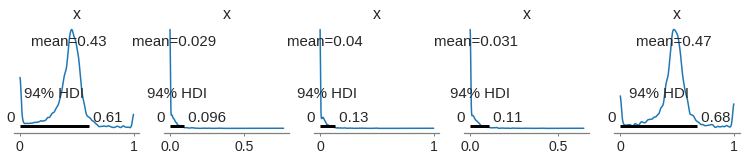

In [102]:
plot_npdfs(s['probs_0'])

In [103]:
1./nYlevels

0.2

**Check**
The uniform probabilty is 1/nYlevels for each of the categories. Prior Predictive should show this number I guess.

In [104]:
s['cuts']

array([[ 0.5       ,  1.412388  ,  5.010449  ,  3.5       ],
       [ 0.5       ,  4.2728267 ,  2.2926705 ,  3.5       ],
       [ 0.5       ,  0.7884229 , -0.19014429,  3.5       ],
       ...,
       [ 0.5       ,  0.9094976 ,  1.0178791 ,  3.5       ],
       [ 0.5       ,  2.524146  ,  3.3286169 ,  3.5       ],
       [ 0.5       , -2.66566   ,  2.9632213 ,  3.5       ]],
      dtype=float32)

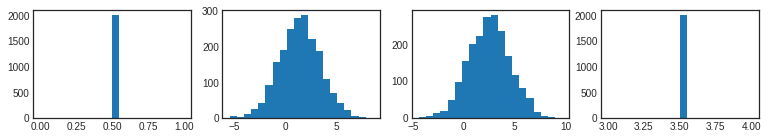

In [105]:
plot_npdfs(s['cuts'], method='hist')

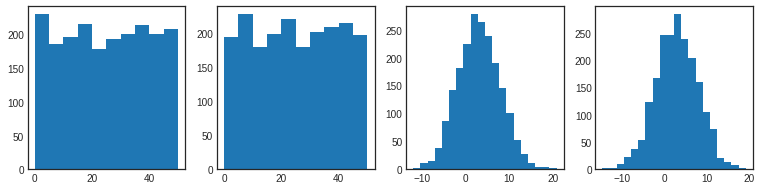

In [106]:
fig, axes = plt.subplots(1,4, figsize=(13,3))
axes[0].hist(s['sigma_0']);
axes[1].hist(s['sigma_1']);
axes[2].hist(s['mu_0'], bins=20);
axes[3].hist(s['mu_1'], bins=20);

### MCMC Inference

In [107]:
%%time
data = dict(nGroups=nGroups,nYlevels=nYlevels, Amat=getAmat(nYlevels), y=YY)   # for MCMC

ps = mcmc_sampling(model, data)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
cuts_normal[0]      0.04      2.01      0.02     -3.15      3.50  10877.21      1.00
cuts_normal[1]      0.03      0.02      0.03     -0.01      0.06   6474.99      1.00
cuts_normal[2]      0.05      0.03      0.05     -0.00      0.10   6194.54      1.00
cuts_normal[3]     -0.02      2.02     -0.02     -3.38      3.18  11077.12      1.00
          mu_0     -0.31      0.04     -0.31     -0.38     -0.25   5824.50      1.00
          mu_1      0.48      0.03      0.48      0.43      0.53  10299.34      1.00
       sigma_0      1.64      0.04      1.64      1.57      1.70   4852.35      1.00
       sigma_1      1.63      0.03      1.63      1.59      1.69   6750.47      1.00

Number of divergences: 0
CPU times: user 7.89 s, sys: 12.4 ms, total: 7.9 s
Wall time: 7.29 s


In [108]:
[(f'{k:12} ', ps[k].shape) for k in ps.keys()]

[('cdf_0        ', (8000, 5)),
 ('cdf_1        ', (8000, 5)),
 ('cuts         ', (8000, 4)),
 ('cuts_draw    ', (8000, 4)),
 ('cuts_normal  ', (8000, 4)),
 ('diff_0       ', (8000, 5)),
 ('diff_1       ', (8000, 5)),
 ('mu_0         ', (8000,)),
 ('mu_1         ', (8000,)),
 ('probs_0      ', (8000, 5)),
 ('probs_1      ', (8000, 5)),
 ('sigma_0      ', (8000,)),
 ('sigma_1      ', (8000,))]

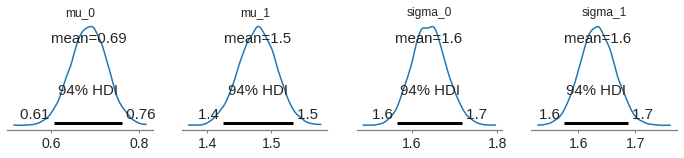

In [109]:
group_names = df.X.unique()
fig, axes = plt.subplots(1, 4, figsize=(12,2))
az.plot_posterior(ps['mu_0'] + 1, ax=axes[0]); axes[0].set_title(f'mu_{group_names[0]}')
az.plot_posterior(ps['mu_1'] + 1, ax=axes[1]); axes[1].set_title(f'mu_{group_names[1]}')
az.plot_posterior(ps['sigma_0'], ax=axes[2]); axes[2].set_title(f'sigma_{group_names[0]}')
az.plot_posterior(ps['sigma_1'], ax=axes[3]); axes[3].set_title(f'sigma_{group_names[1]}') ;

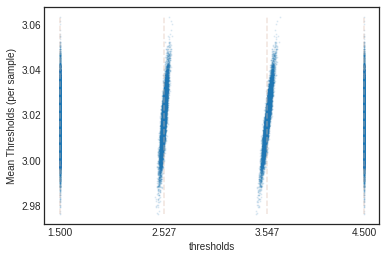

In [110]:
plot_thresholds(ps['cuts'] + 1)  # shift +1 to have DBDA range

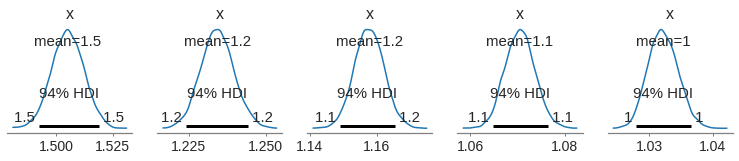

In [111]:
plot_npdfs(ps['probs_1'] + 1)

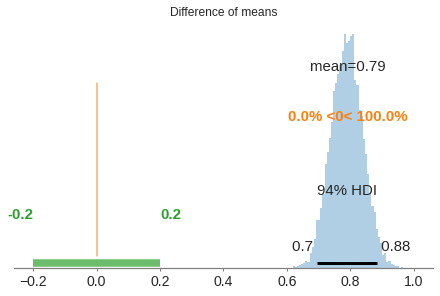

In [112]:
# difference of means
dm = ps['mu_1'] - ps['mu_0']
ax = az.plot_posterior(dm, ref_val=0, rope=[-.2, .2], kind='hist');
ax.set_title('Difference of means');

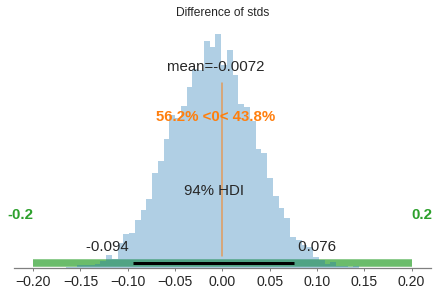

In [113]:
# difference of stds
dm = ps['sigma_1'] - ps['sigma_0']
ax = az.plot_posterior(dm, ref_val=0, rope=[-.2, .2], kind='hist');
ax.set_title('Difference of stds');

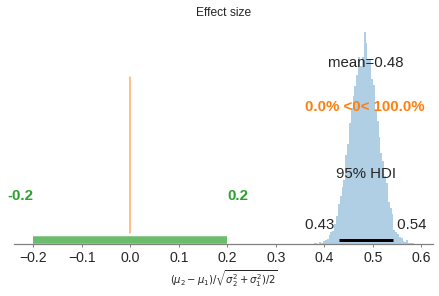

In [114]:
# effect size
dm = (ps['mu_1'] - ps['mu_0']) / np.sqrt((ps['sigma_1']**2 + ps['sigma_0']**2)/2)
ax = az.plot_posterior(dm, ref_val=0, rope=[-.2, .2], kind='hist', hdi_prob=.95);
ax.set_title('Effect size');
ax.set_xlabel('$(\mu_2 - \mu_1)/\sqrt{\sigma_2^2 + \sigma_1^2)/2}$');

In [115]:
#def model(nGroups, nYlevels, Amat, y=None):

# def posterior_predictive(model, ps):
Pred = Predictive(model, posterior_samples=np2jnp(ps))
samples = Pred(random.PRNGKey(0), nGroups, nYlevels, getAmat(nYlevels))
np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
print_shapes(np_samples)

cdf_0         (8000, 5)
cdf_1         (8000, 5)
cuts          (8000, 4)
cuts_draw     (8000, 4)
diff_0        (8000, 5)
diff_1        (8000, 5)
obs_0         (8000,)
obs_1         (8000,)
probs_0       (8000, 5)
probs_1       (8000, 5)


In [116]:
sdf = pd.DataFrame({'obs0': np_samples['obs_0'], 'obs1': np_samples['obs_1']})
sdf = sdf.astype('category')
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   obs0    8000 non-null   category
 1   obs1    8000 non-null   category
dtypes: category(2)
memory usage: 16.2 KB


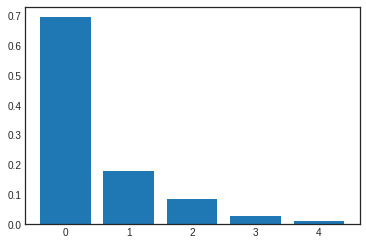

In [117]:
vc0 = sdf.obs0.value_counts(normalize=True)
vc1 = sdf.obs1.value_counts(normalize=True)
plt.bar(x=vc0.index, height=vc0.values);

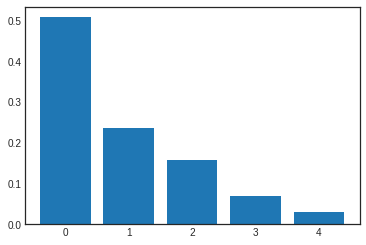

In [118]:
plt.bar(x=vc1.index, height=vc1.values);

**NOTE**

1. DBDA book's categorical values are 1, 2, ...., and the generating density is `Norm(1, 2.5)`
1. The computation here has categorical values 0, 1, ..., therefore the true generating density `Norm(0, 2.5)`
1. The estimated posterior densities from the two models are almost similar to the true density.
1. Likewise, the cutpoint locations have values one less than those in DBDA book.

End.